# Introduction

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy
import seaborn as sns
import surprise

from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import NMF, TruncatedSVD, KernelPCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from surprise import accuracy, AlgoBase
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, RandomizedSearchCV, split

my_seed = 33
random.seed(my_seed)
np.random.seed(my_seed)

The main aim of the project is to present some applications of dimensionality reduction and optimization techniques in recommender systems. The dataset was downloaded from https://grouplens.org/datasets/movielens/ (ml-latest-small.zip) and it contains infomation about ratings of 600 users on 9000 movies. Let's start with a quick glance at the data:

In [2]:
ratings_path = os.path.join(os.getcwd(), os.path.join('ml-latest-small', 'ratings.csv'))
data = pd.read_csv(ratings_path).drop(["timestamp"], axis=1)
data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Each row contains information about userId, movieId (id of the movie that was rated) and rating itself. Even the first 5 rows of the data provide important insight: user 1 didn't rate some movies. This observation can be obviously extended to other users as we rather not expect that there is a person who rate all of the 9000 movies. What if we want to recommend a movie to user 1? Obviously we want to make the best possible recommendation, hence we are looking for movies that were not rated yet and match user 1 preferences. The simplest strategy assume that we have ratings of all the unrated movies and simply select movie with the highest rating. In order to make recommendation we need to fill the gaps in ratings and this is the main role of recommender systems. 

# Exploratory data analysis

In some situations it will be easier to work with the data in Users $\times$ Movies format. This is so called utility matrix of recommendation system. There is one additionall step here. Algorithms of recommender system needs so called training data in order to properly recommend the items of interest. Training data contains ratings that we already know, but in the end we want recommendation for unrated movies. It turns out that trained algorithm work well for training data but it may not generalize well. Solution that is commonly used is based on splitting the data into training and test (unseen) set that will employed when evaluation of the system is carried. In this case train 10: test 1 ratio was proposed. 

In [7]:
def split_dataset(X, test_frac=0.1):
    test_set_size = int(X.shape[0]*test_frac)
    test_idx = np.random.choice(X.index, size=test_set_size, replace=False)
    test_set = X.loc[test_idx, :]
    train_set = X.copy()
    train_set.loc[test_idx, "rating"] = np.NaN
    return train_set, test_set.sort_values(by=["userId", "movieId"]), test_idx

#X_train, X_test, test_idx = split_dataset(data)
#util_matrix = X_train.pivot(index='userId', columns='movieId')

### TESTING

def preprocess_data(X_train, X_test):
    X_train = pd.concat([X_train, X_test])
    X_train.loc[X_test.index, "rating"] = np.NaN
    return X_train, X_test

X_train, X_test = train_test_split(data, test_size=0.1)

reader = Reader()
data_surp = Dataset.load_from_df(data, reader)
surp_train = surprise.Dataset.load_from_df(X_train, reader).build_full_trainset()
surp_test = surprise.Dataset.load_from_df(X_test, reader).build_full_trainset().build_testset()

X_train, X_test = preprocess_data(X_train.sort_index(), X_test.sort_index())
util_matrix = X_train.pivot(index='userId', columns='movieId')

It was already mentioned that there are missing ratings, but the problem is more serious than it may be concluded from the introduction. In the next step we will look at the dataset as a matrix (an image) and color all missing ratings to dark shades and non missing to some colors.

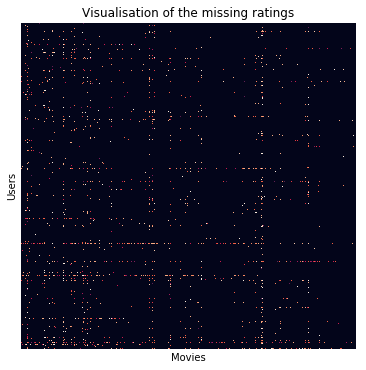

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

cmap = sns.color_palette("YlGnBu", len(data["rating"].unique()))
sns.heatmap(util_matrix.fillna(-1), 
            yticklabels=False, 
            xticklabels=False, 
            #cmap=cmap,
            cbar=False, 
            ax=ax)

ax.set_title('Visualisation of the missing ratings')
ax.set_xlabel('Movies')
ax.set_ylabel('Users');

Now it can be visually observed that the vast majority of votes are missing. Let's make it more more precise:

In [9]:
n_missing = np.sum(util_matrix.isna().values)
n_non_missing = util_matrix.size - n_missing
pd.Series([n_missing, n_non_missing, round(n_missing / util_matrix.size, 3)], index=['n. missing', 'n. non-missing', 'missing/all'])

n. missing        5840888.000
n. non-missing      90752.000
missing/all             0.985
dtype: float64

## Recommendations

Matrix decomposition algorithms require imputation of missing entries in the utlity matrix. One may propose to fill the missing values with zeroes. It's not good idea because it will be the same information as: all users rate unrated movies to zero so they didn't see those movies but they already hate them. Another idea: filling missing values with mean over all non-missing ratings. The result of such approach is sometimes called dummy classifier and it will be treated as a baseline for other algorithms. 

**Side note**: Before testing on test set, proposed algorithms are evaluated with cross-validation. This method gives rough estimator of train test rse. Processing steps can be summarized as follows:
1. Divide the train dataset into $k$ mutually exclusive sets $F_k$
2. For $i \in \{1, ..., k\}$:
    1. Train algorithm on $F_{j \neq i}$
    2. Evaluate algorithm on $F_i$ as it was train set
5. Summarize obtained results

### Dummy recommender

In [10]:
#reader = Reader()
#data_surp = Dataset.load_from_df(data, reader)
#surp_train = surprise.Dataset.load_from_df(X_train, reader).build_full_trainset()
#surp_test = surprise.Dataset.load_from_df(X_test, reader).build_full_trainset().build_testset()

class DummyRecommender(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        return self

    def estimate(self, u, i):
        return self.global_mean
    
cv = split.ShuffleSplit(n_splits=3, test_size=0.1, shuffle=True)
dummy_rec = DummyRecommender()
dummy_cv = cross_validate(dummy_rec, data_surp, verbose=True, cv=cv)

Evaluating RMSE, MAE of algorithm DummyRecommender on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     0.8384  0.8368  0.8113  0.8289  0.0124  
RMSE (testset)    1.0542  1.0541  1.0235  1.0439  0.0145  
Fit time          0.03    0.05    0.04    0.04    0.01    
Test time         0.11    0.03    0.12    0.09    0.04    


In [11]:
# dummy_rse = dummy_cv['test_rmse'].mean()
dummy_rec.fit(surp_train)
predictions = dummy_rec.test(surp_test)
dummy_rse = accuracy.rmse(predictions)
dummy_rse

RMSE: 1.0506


1.0506061303851641

It can be concluded that mean RSE is 1.05. 

### Mean-adjusted recommender

If we think a little about replacing missing values with mean it turns out that this approach doesn't take under considaration two simple situations:
1. Some movies are poor hence they have low rating in general
2. Some users are strict raters hence they tend to give low ratings

These issues might be approached with user ratings baseline and movie ratings baseline. 
$$
r_{x,i} = \mu + b_x + b_i
$$

* $r_{x,i}$ - rating of user x on movie i
* $\mu$ - mean of all non-missing ratings
* $b_x = \text{avg rating of user x} - \mu$
* $b_i = \text{avg rating of movie i} - \mu$

**Side note:** There can be users that didn't rate any movie or movie that weren't rated by any user. It's so called cold start problem. In this case we simply assign $\mu$ as an initial rating.

In [14]:
def adjust_to_mean(df, util_matrix, col):
    group_means = df.groupby(col).aggregate(np.mean)
    util_copy = util_matrix.copy()
    for col in util_copy.columns:
        util_copy.loc[:, col] = group_means.values.reshape(-1)
    return util_copy

class MeanAdjustedRecommender(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        
        dataset = np.array([[uid, iid, r] for (uid, iid, r) in trainset.all_ratings()]).reshape((-1, 3))
        dataset = pd.DataFrame(dataset, columns=['userId', 'movieId', 'rating'])
        dataset = dataset.astype({'userId': 'int32', 'movieId':'int32'})
        util_matrix = dataset.pivot(index='userId', columns='movieId')
        
        user_avg_ratings = adjust_to_mean(dataset.drop('movieId', axis=1), util_matrix, 'userId')
        # User cold start problem
        user_avg_ratings = user_avg_ratings.fillna(self.global_mean)
        
        movie_avg_ratings = adjust_to_mean(dataset.drop('userId', axis=1), util_matrix.T, 'movieId').T
        # Movie cold start problem
        movie_avg_ratings = movie_avg_ratings.fillna(self.global_mean)
        
        self.mean_adj_matrix =  user_avg_ratings + movie_avg_ratings - self.global_mean
        return self

    def estimate(self, u, i):
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return self.mean_adj_matrix.iloc[u, i]
        return self.global_mean

mean_adj_rec = MeanAdjustedRecommender()
cross_validate(mean_adj_rec, data_surp, verbose=True, cv=cv)

Evaluating RMSE, MAE of algorithm MeanAdjustedRecommender on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     0.6991  0.6993  0.6934  0.6973  0.0027  
RMSE (testset)    0.9182  0.9194  0.9066  0.9147  0.0057  
Fit time          7.07    7.12    7.98    7.39    0.42    
Test time         0.63    0.67    0.79    0.70    0.07    


In [15]:
mean_adj_rec.fit(surp_train)
predictions = mean_adj_rec.test(surp_test)
mean_adj_rse = accuracy.rmse(predictions)
mean_adj_rse

RMSE: 0.9260


0.9260497856406061

Predicted ratings rse dropped significantly from 1.0456 (in case of dummy classifier) to 0.9508.

### Matrix factorization

So far 'training' and evaluatng the algorithms was nice and simple, because everything was handled via surprise library. In order to apply basic matrix factorization procedures some preprocessing must be performed as non-iterative (non SGD) methods are not supported. Presented algorithms are suitable only for populated utility matrix, hence some NaN-replacing strategy must be involved. I've decided to do it in mean-adjusted manner described above. 

**Side not**: Because matrix factorization recommender systems doesn't suit sklearn API well, it's somehow difficult to implement cross-validation. Due to this obstacle NMF, SVD1 and SVD2 were validated against test set solely. 

In [17]:
#def get_rse(prediction, test_set):
#    ratings_comparison = prediction.merge(test_set, on=["userId", "movieId"]).loc[:, ["rating_x", "rating_y"]]
#    error = mean_squared_error(ratings_comparison["rating_x"], 
#                               ratings_comparison["rating_y"])
#    return error ** (1/2)

def get_rse(prediction: pd.DataFrame, test_set: pd.DataFrame):
    ratings_comparison = prediction.merge(test_set, on=["userId", "movieId"]).loc[:, ["rating_x", "rating_y"]]
    return np.sqrt(np.mean((ratings_comparison["rating_x"] - ratings_comparison["rating_y"]) ** 2))

grand_mean = X_train.loc[:, "rating"].mean()
user_avg_ratings = adjust_to_mean(X_train.drop('movieId', axis=1), util_matrix, 'userId')
user_avg_ratings = user_avg_ratings.fillna(grand_mean)

movie_avg_ratings = adjust_to_mean(X_train.drop('userId', axis=1), util_matrix.T, 'movieId').T
movie_avg_ratings = movie_avg_ratings.fillna(grand_mean)
 
mean_adjusted_ratings = user_avg_ratings + movie_avg_ratings - grand_mean
util_matrix_filled = util_matrix.mask(np.isnan, other=mean_adjusted_ratings)
# util_matrix_filled = util_matrix_filled.mask(np.isnan, other=grand_mean)

#mean_adj_rse = get_rse(util_matrix_filled.stack().reset_index(), X_test)
#mean_adj_rse

Overview of mean-adjusted utility matrix:

In [19]:
util_matrix_filled.iloc[:5, :5]

rating                                        
movieId         1         2         3         4         5
userId                                                   
1        4.000000  4.277892  4.000000  3.080777  3.891753
2        4.325934  3.870485  3.639279  2.673370  3.484345
3        2.929419  2.473971  2.242764  1.276855  2.087831
4        3.912698  3.457249  3.226043  2.260134  3.071110
5        4.027915  3.572466  3.341260  2.375351  3.186326

## Truncated SVD

**Singular Value Decomposition**: Let Z be a real $n \times d$ matrix where $n \geq d$. Then the matrix Z can be written as a product of three matrices $Z = U \Lambda^{\frac{1}{2}} V^T$ such that
* U is $n \times d$ orthonormal matrix
* V is a $d \times d$ orthonormal matrix
* $\Lambda$ is a $d \times d$ matrix with nonnegative entries

**Truncated SVD**: Let Z be a real $n \times d$ matrix, from SVD we have $Z = U \Lambda^{\frac{1}{2}} V^T$. Let $\lambda_1 \geq ... \geq \lambda_n \geq 0$ be the eigenvalues of $Z Z^T$. Ley $U_r$ denote the matrix consisitng of first r columns of $U$ and similarily let $V_r$ denote the first r columns of $V$, $r<d$.  Additionally, let $\Lambda_r$ be a square $r \times r$ matrix - truncated $\Lambda$ to first r rows and columns. Define $\hat{Z} = U_r \Lambda_r^{\frac{1}{2}} V_r^t$. We have:
$$
|| Z - \hat{Z}_r^2 || = \Sigma_{r+1}^d \lambda_i
$$

With that being said let's build some intuition of how to incorporate these theorems to recommender systems. It's quite obvious that SVD theorem as it is doesn't help in our problem. It can give different representation of input matrix, but we are not particullary interested in such metamorphosis as we are looking for missing values. Things got more interesting with Truncated SVD. 

In our case $n$ is number of users and $d$ in number of movies. We might think of decomposition elements as follows:
* U - users to concepts matrix
* $\Lambda$ - strengths of concepts matrix
* V^T - movies to concepts matrix

The concepts is a meta-concept that we try to capture and which is responsible for ratings differentiation. We hope that in concepts space there is direct link between user preferences and movie. Now the main interest is $\Lambda$ matrix because it describes core of concepts. We have that $\lambda_1 \geq ... \geq \lambda_n \geq 0$ so the strongest concepts are grouped on diagonal in the right upper corner. Truncated SVD theorem can be read as removing an influence of redundant (noise) concepts from Z matrix. This procedure gives $\hat{Z}$ as a result. 

The problem is how we should choose parameter $r$ which represent the number of important concepts. There is no direct answer and it is obrained via searching parameter space and compare results against test set.

In [20]:
svd = TruncatedSVD()

svd_dict = {}
for n_components in range(8, 30, 2):
    svd.n_components = n_components
    svd.fit(util_matrix_filled)
    sigma = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(util_matrix_filled)/svd.singular_values_
    H = np.dot(sigma ,VT)
    svd_prediction = W @ H
    svd_prediction = pd.DataFrame(svd_prediction, 
                                  columns=util_matrix_filled.columns, 
                                  index=util_matrix_filled.index)
    svd_dict[n_components] = [get_rse(svd_prediction.stack(), X_test), 
                              svd.explained_variance_ratio_.sum()]

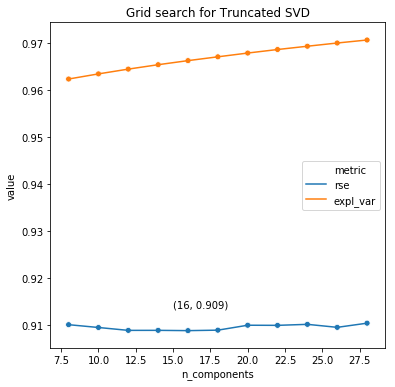

In [21]:
svd_df = pd.DataFrame.from_dict(svd_dict)
min_idx = svd_df.loc[0, :].idxmin()
svd_rse = svd_df.loc[0, :].min()

svd_df["value"] = ["rse", "expl_var"]
svd_df.set_index("value", inplace=True)
svd_df = svd_df.T.stack().reset_index()
svd_df.columns = ["n_components", "metric", "value"]

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax)
sns.scatterplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax, legend=False)

ax.text(min_idx-1, svd_rse+0.005, str((min_idx, round(svd_rse, 3))))
ax.set_title('Grid search for Truncated SVD');

There is around 0.2 reduction in rse when compared to mean adjusted recommendation - not that bad. 

## Iterative (but not gradient-based) SVD 

Iterative SVD is an approach when wishfull thinkink actually works (sometimes). The idea is that we extract $r$ concepts as it was previously, but this time we try to focus on ratings that were already given. Fristly we set $Z^{(0)} = SVD_r[Z]$ as our initial guess. Then we iteratively compute $Z^{(n+1)} = SVD_r[Z \text{ if } z_{ij} >0 \text{ and } Z^{(n)} \text{ elsewhere }]$. Iterations are repeated until $Z^{(n_0 + 1)} = Z^{(n_0)}$. Unfortunatelly this algorithm may not converge. 

In [22]:
svd_opimal_comp = svd_df[svd_df["metric"] == "rse"][["value"]].idxmin()[0]
svd_iter = TruncatedSVD(n_components=svd_opimal_comp)

def if_converged():
    return np.all(np.isclose(Z_0, Z_next, rtol=1, atol=1))

def if_exceed_max_iter(i, max_iter=45):
    return i > max_iter

i = 1
Z_0 = util_matrix_filled.copy()
nan_indices = util_matrix.isna()
while not if_exceed_max_iter(i):
    svd_iter.fit(Z_0)
    sigma = np.diag(svd_iter.singular_values_)
    VT = svd_iter.components_
    W = svd_iter.transform(util_matrix_filled)/svd_iter.singular_values_
    H = np.dot(sigma ,VT)
    Z_next = W @ H
    Z_next = pd.DataFrame(Z_next, columns=util_matrix_filled.columns, index=util_matrix_filled.index)
    if if_converged():
        print('Converged')
        break
    Z_0 = Z_0.mask(nan_indices, Z_next)
    i += 1

Converged


In [24]:
svd_iter_rse = get_rse(Z_next.stack(), X_test)
svd_iter_rse

0.904751051083125

In this case algorithm didn't converge, hence the iteretions were stopped after 45 updates. It also gave slightly improvement in comparison to previous algorithms. 

## NMF

For SVD we had $Z = U \Lambda^{\frac{1}{2}} V^T = UH$. For NMF we will assume that $Z = WH$ and $U$ and $H$ must be nonnegative. It can be formalized in terms of optimization problem as follows:

Given Z of size $n \times d$ find:
$$
argmin_{W, H} \{dist(Z, WH)\} \text{, such that W, H } \geq 0
$$

Similarily to SVD we need to choose the W and H dimension parameter $r$.

In [27]:
epsilon = 10e-4
nmf_offset = abs(np.min(util_matrix_filled.values)) + epsilon
nmf_model = NMF(init='random')

rse_info = {}
# n_components <= min(132, 4841)
for n_components in range(20, 45, 5):
    nmf_model.n_components = n_components
    W = nmf_model.fit_transform(util_matrix_filled + nmf_offset)
    H = nmf_model.components_
    X_approx = np.dot(W,H) - nmf_offset
    X_approx = pd.DataFrame(X_approx, columns=util_matrix.columns, index=util_matrix.index)
    rse_info[n_components] = get_rse(X_approx.stack().reset_index(), X_test)

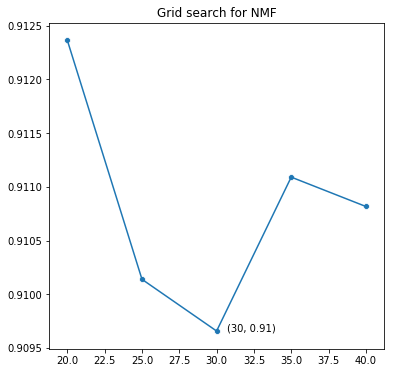

In [28]:
rse_series = pd.Series(rse_info)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(data=pd.Series(rse_series), label="line", ax=ax)
sns.scatterplot(data=rse_series)

min_idx = rse_series.idxmin()
nmf_rse = rse_series.min()
ax.text(min_idx+.7, nmf_rse, str((min_idx, round(nmf_rse, 3))))

ax.legend_.remove()
ax.set_title('Grid search for NMF')
ax;

I seems that 0.9 rse is a limit performance for simple decomposition strategies.

## Kernel PCA

In [ ]:
#kpca = KernelPCA(fit_inverse_transform=True, gamma=10)
#kpca_dict = {}
#for kernel in ["rbf", "poly"]:
#    kpca.kernel = kernel
#    kpca_prediction = kpca.fit_transform(util_matrix_filled - grand_mean)
#    kpca_prediction = kpca.inverse_transform(kpca_prediction)  + grand_mean
#    kpca_prediction = pd.DataFrame(kpca_prediction, 
#                                   columns=util_matrix_filled.columns, 
#                                   index=util_matrix_filled.index)
#    kpca_dict[kernel] = get_rse(kpca_prediction.stack(), X_test)

In [ ]:
#kpca_dict

### SGD-Based SVD

Let's rephrase the optimization problem. We want to decompose utility matrix $Z$ into product of two matrices $W$ and $H$. Now we want to find $W$ and $H$ such that they minimize the following function:
$$
f(W, H) = \Sigma_{(i, j): z_{ij} \neq NaN}(z_{ij} - w_i^Th_j)^2 + \lambda(||w_i||^2 + ||h_j||^2)
$$
* $h_j$ - jth column of H
* $w_i^T$ - ith row of W

Function f is multivariable function that can be minimized with iterative approach called stochastic gradient descent. The idea is simple, we iteratively make small steps in direction opposite to gradient. This procedure should lead us to local minimum as gradient show the direction of growth. 

1. Compute: $e_{ij} = z_{ij} - w_i^T h_j$
2. Update: 
    1. $w_i := w_i + \eta(e_{ij}h_j - \lambda w_i)$
    2. $h_j := h_j + \eta(e_{ij}w_j -\lambda h_j)$

Cost function was written in regularized form becase we added additionall term $\lambda(||w_i||^2 + ||h_j||^2)$. This is common practice in machine learning to prevent overfitting. Overfitting is a situation when algorithm fits wery well to training data but it is not able to generalize well for unseen data (for example test set). 

Is there something else that we can do? Actually there is. Recall that in mean-adjusted approach we've tried to involve the fact that some users give low ratings in general (haters) and some movies are poor, hence they ratings are below the average. This idea can be easily added to the cost function:
$$
f(W, H) = \Sigma_{(i, j): z_{ij} \neq NaN}(z_{ij} - (\mu + b_i + b_j + w_i^Th_j))^2 + \lambda(||w_i||^2 + ||h_j||^2 + \Sigma_i||b_i||^2 + \Sigma_j||b_j||^2)
$$

We basically inject two additionall degrees of freedom per user and movie. 
* $b_i$ - baseline for ith user
* $b_j$ - baseline for jth movie
* $\mu$ - mean of all ratings

One might ask why we don't want to compute $b_i$ and $b_j$ as it was done previously. Actually we can but in this case we believe that SGD will do that for us. It turns out that it gives better results in general.

Surprise gives nice mechanism to find the best alrogithm parameters. It's called RandomizedSearchCV. The only thing that we need to do is pass the dictionary of potentiall parameter values and the number of iterations. This function will automatically pick randomized combinations and return the best model.

In [29]:
# lr_all – The learning rate for all parameters. Default is 0.005.
# reg_all – The regularization term for all parameters. Default is 0.02
param_grid = {'n_epochs': [5, 10, 20, 30], 
              'lr_all': [0.007, 0.009, 0.01],
              'reg_all': [0.05, 0.1, 0.2, 0.4]}

gs =  RandomizedSearchCV(SVD, 
                         param_grid, 
                         measures=['rmse'], 
                         cv=cv,
                         return_train_measures=True,
                         refit=True,
                         n_iter=15, 
                         n_jobs=3)
gs.fit(data_surp)
svd_sgd = gs.best_estimator
cross_validate(svd_sgd['rmse'], data_surp, verbose=True, cv=cv)

#print(gs.best_params['rmse'])
#0.8541955377814917
#{'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.05}
#svd_sgd_rse = svd_sgd_cv['test_rmse'].mean()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     0.6547  0.6404  0.6491  0.6481  0.0059  
RMSE (testset)    0.8521  0.8337  0.8437  0.8432  0.0075  
Fit time          7.46    7.78    7.58    7.61    0.13    
Test time         0.08    0.07    0.07    0.07    0.00    


In [60]:
svd_sgd = svd_sgd['rmse']
svd_sgd.fit(surp_train)
predictions = svd_sgd.test(surp_test)
svd_sgd_rse = accuracy.rmse(predictions)
svd_sgd_rse

RMSE: 0.8681


0.8681137163193676

Parameters selected by grid search:

In [37]:
print(gs.best_params['rmse'])

{'lr_all': 0.01, 'n_epochs': 30, 'reg_all': 0.05}


## Models comparison

There are no doubts that the winner is SVD with SGD optimizer. 

In [31]:
comparison = {"Dummy": dummy_rse, 
              "Mean Adj": mean_adj_rse,  
              "NMF": nmf_rse, 
#               "Poly PCA": kpca_dict['poly'],
#               "Rbf PCA": kpca_dict['rbf'],
              "SVD": svd_rse,
              "SVD + SGD": svd_sgd_rse}
pd.Series(comparison).round(5)

Dummy        1.05061
Mean Adj     0.92605
NMF          0.90966
SVD          0.90876
SVD + SGD    0.84317
dtype: float64

Finally we can make a recommendation for user 1:

In [94]:
pred = [p for p in predictions if p.uid==1]
unseen = X_test.loc[X_test["userId"] == 1, "movieId"]
pred = [p for p in pred if p.iid in unseen.values]
pred = sorted(pred, key=lambda p: p.r_ui)[::-1]
pred = pd.Series([p.est for p in pred])

As we can see our user is rather generous and he tend to give high ratings.

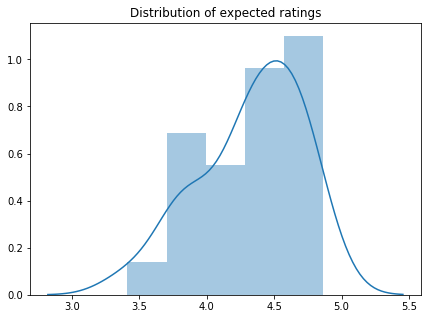

In [107]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
sns.distplot(pred, ax=ax)
ax.set_title("Distribution of expected ratings");

This simple summary contains the following information, expected_rating : unseen movies with such rating.

In [103]:
Counter(pred.round())

Counter({3.0: 1, 4.0: 14, 5.0: 10})